# Temporal Convergence of ETDRK schemes

Inspired by figure 4.2 (a) in

Montanelli, H. and Bootland, N., 2020. Solving periodic semilinear stiff PDEs in
1D, 2D and 3D with exponential integrators. Mathematics and Computers in
Simulation, 178, pp.307-327.

this notebook assesses the convergence of all available ETDRK schemes in
`Exponax`. It does so by having four different steppers (same constitutive
parameters to the conservative KS equation) integrate an initial condition to a
state after 10 time units with various different $\Delta t$ (and hence also
increasingly many time steps the smaller $\Delta t$ is). The error is then
calculated against the solution using the finest $\Delta t$.

In a loglog plot, we observe polynomially linear, quadratic, cubic, and quartic
convergence for the first, second, third, and fourth order ETDRK schemes,
respectively.

We measure the error in terms of the relative $L^2$ norm of the difference
between the numerical solution at the current $\Delta t$ and the reference
solution at the finest $\Delta t$.

$$
\text{error} = \frac{\|u_{\Delta t} - u_{\Delta t_{\text{ref}}}\|_{L^2(\Omega)}}{\|u_{\Delta t_{\text{ref}}}\|_{L^2(\Omega)}}
$$

In discrete terms, this can be realized by the normalized root mean square error
(nRMSE).

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [2]:
# Switch to double precision
jax.config.update("jax_enable_x64", True)

In [3]:
import exponax as ex

In [4]:
# Choosing a reasonably high number of points (with domain_extent=60.0, the KS
# in single precision has populated modes up to wavenumber ~80. Hence using >160
# points gives essentially no spatial discretization error. Hence, we can fully
# focus on the error due to integration in time.)
N = 256

In [5]:
u_0 = ex.ic.RandomTruncatedFourierSeries(1)(N, key=jax.random.PRNGKey(0))

2024-09-23 12:49:32.974648: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.68). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [6]:
dt_range = 2.0 ** (-jnp.arange(2, 12))

In [7]:
dt_range

Array([0.25      , 0.125     , 0.0625    , 0.03125   , 0.015625  ,
       0.0078125 , 0.00390625, 0.00195312, 0.00097656, 0.00048828],      dtype=float64)

In [8]:
def compute_state_at_10(dt, order):
    num_steps = int(10.0 / dt)
    repeated_stepper = ex.RepeatedStepper(
        ex.stepper.KuramotoSivashinskyConservative(1, 60.0, N, dt, order=order),
        num_steps,
    )
    returned = repeated_stepper(u_0)
    return returned

In [9]:
result_states_1 = jnp.array([compute_state_at_10(dt, 1) for dt in dt_range])
result_states_2 = jnp.array([compute_state_at_10(dt, 2) for dt in dt_range])
result_states_3 = jnp.array([compute_state_at_10(dt, 3) for dt in dt_range])
result_states_4 = jnp.array([compute_state_at_10(dt, 4) for dt in dt_range])

In [10]:
rel_errors_1 = jnp.array(
    [ex.metrics.nRMSE(u, result_states_1[-1]) for u in result_states_1][:-1]
)
rel_errors_2 = jnp.array(
    [ex.metrics.nRMSE(u, result_states_2[-1]) for u in result_states_2][:-1]
)
rel_errors_3 = jnp.array(
    [ex.metrics.nRMSE(u, result_states_3[-1]) for u in result_states_3][:-1]
)
rel_errors_4 = jnp.array(
    [ex.metrics.nRMSE(u, result_states_4[-1]) for u in result_states_4][:-1]
)

In [11]:
dt_range_reduced = dt_range[:-1]

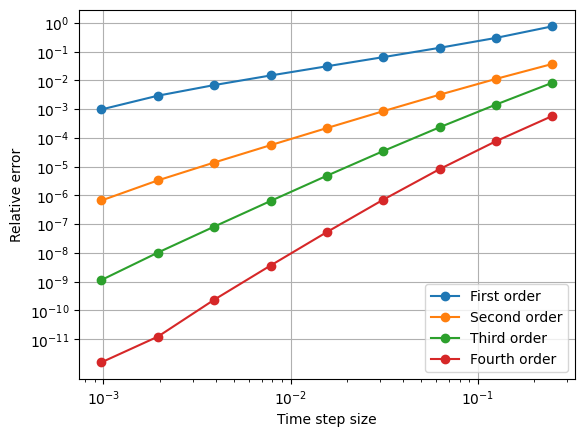

In [12]:
plt.loglog(dt_range_reduced, rel_errors_1, "o-", label="First order")
plt.loglog(dt_range_reduced, rel_errors_2, "o-", label="Second order")
plt.loglog(dt_range_reduced, rel_errors_3, "o-", label="Third order")
plt.loglog(dt_range_reduced, rel_errors_4, "o-", label="Fourth order")
plt.xlabel("Time step size")
plt.ylabel("Relative error")
plt.legend()
plt.yticks(
    [1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11],
)
plt.grid()

In [13]:
def compute_convergence_rate(errors):
    finest = errors[2:]
    fine = errors[1:-1]
    coarse = errors[:-2]
    factor = (coarse - fine) / (fine - finest)
    return jnp.log(factor) / jnp.log(2.0)

In [14]:
convergence_rates_1 = compute_convergence_rate(rel_errors_1)
convergence_rates_2 = compute_convergence_rate(rel_errors_2)
convergence_rates_3 = compute_convergence_rate(rel_errors_3)
convergence_rates_4 = compute_convergence_rate(rel_errors_4)

In [15]:
convergence_rates_1, convergence_rates_2, convergence_rates_3, convergence_rates_4

(Array([1.48017438, 1.20098716, 1.09633277, 1.04742766, 1.02355578,
        1.01174108, 1.00586162], dtype=float64),
 Array([1.68338196, 1.79811745, 1.883822  , 1.93732912, 1.96757454,
        1.98358097, 1.99175836], dtype=float64),
 Array([2.49810195, 2.60026756, 2.72694438, 2.83703527, 2.91111544,
        2.95391233, 2.97682663], dtype=float64),
 Array([2.86942868, 3.19226336, 3.50906618, 3.72809117, 3.85845911,
        3.92865792, 4.38288168], dtype=float64))

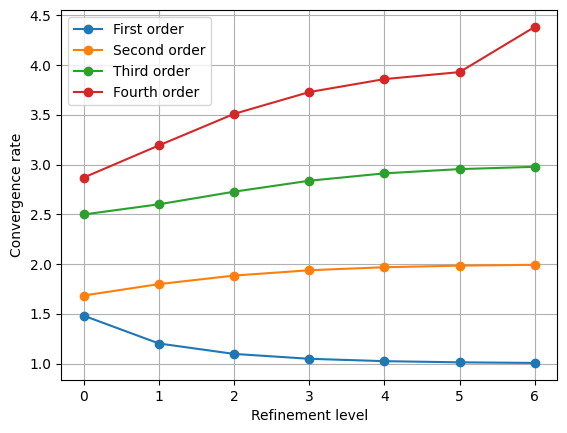

In [16]:
plt.plot(convergence_rates_1, "o-", label="First order")
plt.plot(convergence_rates_2, "o-", label="Second order")
plt.plot(convergence_rates_3, "o-", label="Third order")
plt.plot(convergence_rates_4, "o-", label="Fourth order")
plt.xlabel("Refinement level")
plt.ylabel("Convergence rate")
plt.legend()
plt.grid()